In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
import time
import numba as nb
from tqdm import tqdm

In [2]:
dt = 100
sim_lim = 1000
skip_points = 10
G = 6.67e-11
error = 1
test3_extra_UFOs = 2

def random_UFO():
    return CosmicBody(float(rnd.randrange(1e22, 1e23, 1.0e19)),
                      np.array([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))]),
                      np.array([float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8))]))

In [5]:
@nb.njit
#Function1: Returns norm of vector
def norm(vec: np.ndarray):
    return np.linalg.norm(vec, ord = 2)

@nb.njit
#Function2. Gets on input: Mass and radius. Returns: acceleration
def accelerate(M: float, r: np.ndarray):
    return G * M * r / norm(r) ** 3
    
#Class1:   
class Star:
    #C1.Function1. Gets on input: Mass and radius(def = 0). Returns: None
    def __init__(self, mass: float, radius = 0.):
        self.mass = mass
        self.vec_P = [0, 0, 0]
        self.radius = radius
    #C2.Function2. Gets on input: Name of the star. Returns: All initialased information
    def __str__(self):
        return f"Mass:{self.mass} Radius:{self.radius}"

#Class2:  
class CosmicBody:
    #C2.Function1. Gets on input: Mass, velocity vector, coordinate vector. Returns: None
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray):
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.coords = ([self.vec_P[0], self.vec_P[1], self.vec_P[2]])
        self.destroy_flag = False
        self.id = id(self)
    #C2.Function2. Gets on input: Name of the body. Returns: All initialased information
    def __str__(self):
        return f"Mass:{self.mass} Velocity:({self.vec_v[0]}, {self.vec_v[1]}, {self.vec_v[2]}) Coordinate:({self.vec_P[0]}, {self.vec_P[1]}, {self.vec_P[2]})"
    #C2.Function3. Gets on input: Name of the body. Returns: Kinetic energy of object
    def E_k(self):
        return self.mass * norm(self.vec_v) ** 2 / 2

#Function3. Gets on input: One body and array of bodies. Returns: None(but checkes is the body destryoed and changed the flag)
def try_destroy(self_UFO: CosmicBody, UFO: [CosmicBody, Star]):
    if isinstance(UFO, Star):
        if norm(self_UFO.vec_P - UFO.vec_P) < 1000:
            self_UFO.destroy_flag = True
    else:
        if norm(self_UFO.vec_P - UFO.vec_P) < 1000:
            UFO.destroy_flag = True
            self_UFO.destroy_flag = True

#Function4. Gets on input:One star and list of bodies. Doing 1 iterarion of interaction between bodies in system Returns:None
def gravitate(star: Star, UFOs: list):

    UFOs_copy = copy.deepcopy(UFOs)
    for UFO, UFO_copy in zip(UFOs, UFOs_copy):
        try_destroy(UFO, star)
        UFO_copy.destroy_flag = UFO.destroy_flag
        if UFO.destroy_flag == True:
            continue
        dv = accelerate(star.mass, - UFO.vec_P) * dt
        UFO.vec_v += dv
        UFO.vec_P += UFO.vec_v * dt
        for NEW_UFO in UFOs:
            if NEW_UFO.id != UFO.id:
                try_destroy(UFO, NEW_UFO)
                UFO_copy.destroy_flag = UFO.destroy_flag
        for UFO1 in UFOs_copy:
            if UFO1.id == UFO.id or UFO1.id == True:
                continue
            dv = accelerate(UFO1.mass, UFO_copy.vec_P - UFO1.vec_P)*dt
            UFO.vec_v += dv
            UFO.vec_P += UFO.vec_v * dt
        UFO.coords = np.column_stack((UFO.coords, [UFO.vec_P[0], UFO.vec_P[1], UFO.vec_P[2]]))
            
#Function6. Gets on input: Names of two UFOs. Returns: potential energy of 2 UFOs     
def E_p(UFO1, UFO2):
    return G * UFO1.mass * UFO2.mass / norm(UFO1.vec_P - UFO2.vec_P)

#Function7. Gets on input: Name of the star and names of two UFOs. Returns full system energy (potential + kinetic)
def E_full(star: Star, UFOs: np.ndarray):
    E = 0
    for i in range(len(UFOs)):
        E += E_p(UFOs[i], star) + UFOs[i].E_k()
        for j in range(i + 1, len(UFOs)):
            E += E_p(UFOs[i], UFOs[j])
    return E

#Function8. Gets on input: Name of the star and names of the UFO. Returns: Orbit type of UFO.
def orbit_type(star: Star, UFO: CosmicBody):
    E = E_p(star, UFO) - UFO.E_k()
    if E > 0:
        return 'Elliptic'
    elif E < 0:
        return 'Hyperbolic(Leaves an interaction area)'
    else:
        return 'Parabolic(Leaves an interaction area)'    

    
system_of_2 = np.array([random_UFO(), random_UFO()])
system_of_2_copy = copy.deepcopy(system_of_2)
system_of_3 = np.array([random_UFO(), random_UFO(), random_UFO()])
system_of_4 = np.array([random_UFO(), random_UFO(), random_UFO(), random_UFO()])
Сириус = Star(1e31)
zero = Star(0)

Проверка ЗСЭ

In [6]:
def test1(star, UFOs: np.ndarray):
    print('Test №1: Energy error estimation')
    E_initial = E_full(star, UFOs)
    print('Original system full energy:', E_initial)
    i = 0
    E_arr = []
    while np.abs(E_full(star, UFOs)/E_initial - 1) < error and i < sim_lim:
        gravitate(star, UFOs)
        i += 1
        E_arr.append(E_full(star, UFOs))
    print('Finite system full energy:', E_full(star, UFOs))
    if i == sim_lim:
        print(
            f"For {i} iterations we have {round(np.abs(E_full(star, UFOs)/E_initial - 1)*100,1)}% relative error guaranteed")
    else:
        print(f"For {i} iterations needed to guarantee {round(error*100,1)}% relative error(sad)")

test1(Сириус, system_of_2)

Test №1: Energy error estimation
Original system full energy: 1.5067353101494503e+33
Finite system full energy: 1.385780486880388e+33
For 1000 iterations we have 8.0% relative error guaranteed


Проверка на уничтожение

In [7]:
Earth = CosmicBody(1e23, np.array([4., 2., 8.]), np.array([1., 2., 3.]))

def test2(UFO1, UFO2):
    print('\nTest №2:')
    try_destroy(Earth, Сириус)
    if Earth.destroy_flag == True: 
        print('Destructed sucsessfully')
    else: print('Missed')
    
test2(Earth, Сириус)


Test №2:
Destructed sucsessfully


Действие gravitate со звездой

In [ ]:
def test3(star, UFOs: np.ndarray):
    print('\nTest №3:')
    for UFO in UFOs:
        print(UFO)
    for i in range(sim_lim):
        gravitate(star, UFOs)

def test3plot(star, UFOs: np.ndarray):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for UFO in UFOs:
        ax.scatter(UFO.coords[0][::skip_points], UFO.coords[1][::skip_points],
                   UFO.coords[2][::skip_points], marker='.', s=10)
        ax.scatter(UFO.coords[0][0], UFO.coords[1]
                   [0], UFO.coords[2][0], color='black', label='spawn point', s = 10)
    ax.set_title('Test №3')
    ([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))])
test3(Сириус, system_of_2_copy)
test3plot(Сириус, system_of_2_copy)

Проверим моделирование системы, когда в случайные моменты времени появляются новые тела (4UFO's)

In [ ]:
def test3(star, UFOs: np.ndarray):
    print('\nTest №3: adding bodies in random time')
    time = np.array(
        [rnd.randrange(0, sim_lim, 1) * dt for j in range(test3_extra_UFOs)])
    time.sort()
    print('Random timings:', time)
    for t in range(sim_lim):
        if float(t) * dt in time:
            something = random_UFO()
            UFOs = np.append(UFOs, something)
        for UFO in UFOs:
            gravitate(star, UFOs)
    return UFOs


def test3_plot(star, UFOs: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for UFO in UFOs:
        ax.scatter(UFO.coords[0][::skip_points], UFO.coords[1][::skip_points],
                   UFO.coords[2][::skip_points], s = 10)
        ax.scatter(UFO.coords[0][0], UFO.coords[1]
                   [0], UFO.coords[2][0], color = 'Black', label = 'spawn point', s=10)
    ax.set_title('Test №3')
    
    
    
test3_res = test3(Сириус, system_of_3)
test3_plot(Сириус, test3_res)

Проверяем работу функции проверки типа орбиты (orbit_type())

In [ ]:
def test4(star, UFO):
    print('\nTest №4: testing orbyt_type function')
    print(orbit_type(star, UFO))
    for i in range(sim_lim):
        gravitate(star, np.array([UFO]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(star.vec_P[0], star.vec_P[1], star.vec_P[2], marker='*', s = 130)
    ax.scatter(UFO.coords[0][::skip_points], UFO.coords[1][::skip_points],
                   UFO.coords[2][::skip_points], s=7)
    ax.scatter(UFO.coords[0][0], UFO.coords[1]
               [0], UFO.coords[2][0], color='red', label = 'spawn point')
    ax.set_title('Test №4')
    
UFO = random_UFO()
test4(Сириус, UFO)

<IPython.core.display.Javascript object>


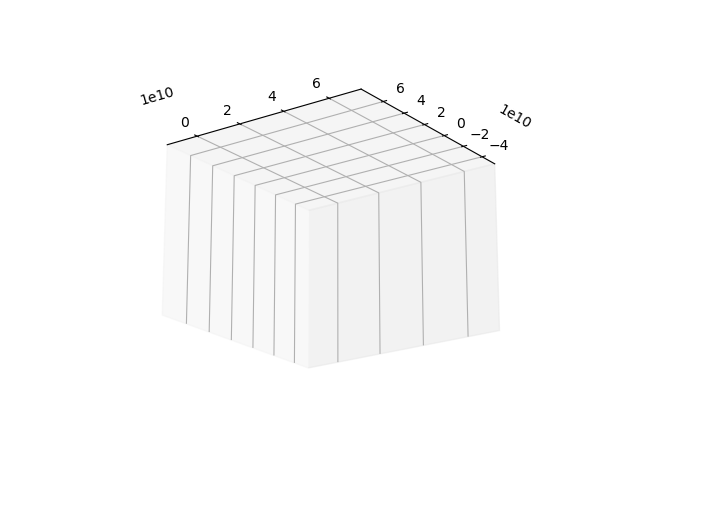

 60%|███████████████████████▎               | 599/1000 [01:38<01:05,  6.10it/s]


KeyboardInterrupt: 

In [10]:
%matplotlib notebook
def test_animation(star: Star, UFOs: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.show()
    fig.canvas.draw()
    
    for t in tqdm(np.arange(0., sim_lim * dt, dt)):
        angle = 60 + 60 * t / sim_lim 
        gravitate(star, UFOs)
        ax.clear()
        
        ax.scatter(0, 0, 0, marker = '*', s = 130)
        for UFO in UFOs:
            ax.scatter(UFO.coords[0][::int(skip_points/10)], UFO.coords[1][::int(skip_points/10)],
                   UFO.coords[2][::int(skip_points/10)], s = 10)
        ax.view_init(30 - angle * 0.2, angle)
        fig.canvas.draw()
    
test_animation(Сириус, system_of_4)